In [1]:
import datetime, time
import platform
import simpy
import shapely.geometry
from simplekml import Kml, Style
import numpy as np

import halem.Base_functions as halem
import halem.Mesh_maker as Mesh_maker
import halem.Functions as Functions
import halem.Calc_path as Calc_path

import pickle
import networkx as nx

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import griddata

import netCDF4
from netCDF4 import Dataset, num2date
from scipy.spatial import Delaunay
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def scale_bar_left(ax, bars=4, length=4, location=(0.1, 0.05), linewidth=3, col='black'):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'white'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'white':
            barcol = 'dimgrey'
        else:
            barcol = 'white'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby, str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col)

In [2]:
coords_WGS = np.loadtxt('E:/Use_case_Schouwen/baty_WGS.csv')  

load_factor =np.array([0])                      # Roadmap11
 
start = [3.674, 51.70969009]                          # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 425_500                                      # Total volume to be dregded                             (m^3)

unloading_rate = 1.5
loading_rate = 1.5
ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 20                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 4000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 6.5                                          # Draft when maximal Loaded                              (m)
T_emp = 3.5                                           # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 4000                                      # Weight empty                                           (tf)

vship = [[V_emp]]

In [3]:
files = [
    '01_DCSM-FM_100m/Roadmap11SIM',
    '02_DCSM-FM_100m NB3/Roadmap11SIM',
    '03_Zuno_real_data/Roadmap11SIM',
    '03_Zuno_real_data NB3/Roadmap11SIM'
]

Paths = []
time_paths = []
distances = []

for name_textfile_load in files:
    print('done')
    with open(name_textfile_load, 'rb') as input:
        Roadmap = pickle.load(input)



    ind = halem.Calc_path.Has_route.find_startstop(None, start[::-1], Roadmap.nodes)
    ind = np.argwhere(Roadmap.WD[ind,:] == Roadmap.WD[ind,75:125].max())[0][0]
    print(Roadmap.WD[ind,75:125].max(), name_textfile_load)
    t0 = datetime.datetime.fromtimestamp(Roadmap.t[ind]+12).strftime('%d/%m/%Y %H:%M:%S')

    Path, timePath, dist = halem.HALEM_time(start,
                                            stop,
                                            t0 ,
                                            vship[0][0],
                                            Roadmap
                                           )

    Paths.append(Path)
    time_paths.append(timePath)
    distances.append(dist)


    ind = halem.Calc_path.Has_route.find_startstop(None, start[::-1], Roadmap.nodes)
    ind = np.argwhere(Roadmap.WD[ind,:] == Roadmap.WD[ind,:].min())[0][0]
    print(Roadmap.WD[ind,75:125].min(), name_textfile_load)
    t1 = datetime.datetime.fromtimestamp(Roadmap.t[ind]).strftime('%d/%m/%Y %H:%M:%S')

    Path2, timePath2, dist2 = halem.HALEM_time(start, 
                                               stop,
                                               t1 ,
                                               vship[0][0],
                                               Roadmap
                                              )
    Paths.append(Path2)
    time_paths.append(timePath2)
    distances.append(dist2)


done
16.819456392313686 01_DCSM-FM_100m/Roadmap11SIM
6.766525443656578 01_DCSM-FM_100m/Roadmap11SIM
done
16.819456392313686 02_DCSM-FM_100m NB3/Roadmap11SIM
6.766525443656578 02_DCSM-FM_100m NB3/Roadmap11SIM
done
12.861028989796681 03_Zuno_real_data/Roadmap11SIM
13.398964103121996 03_Zuno_real_data/Roadmap11SIM
done
12.861028989796681 03_Zuno_real_data NB3/Roadmap11SIM
13.398964103121996 03_Zuno_real_data NB3/Roadmap11SIM


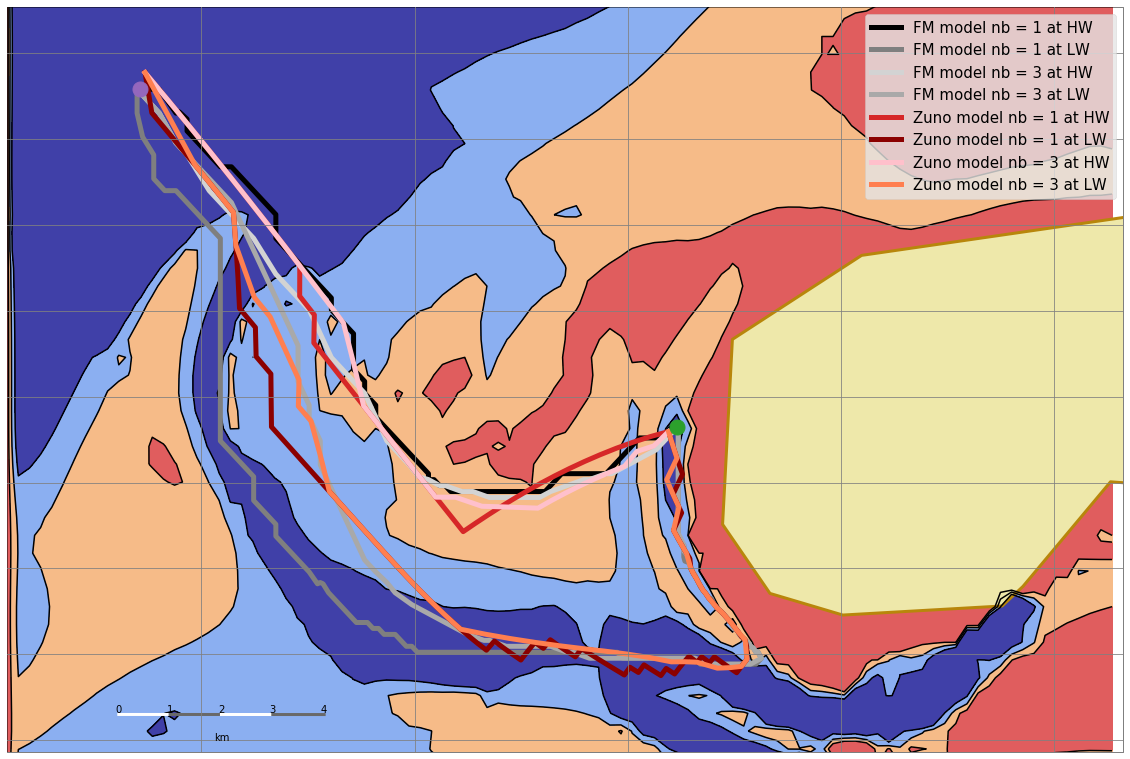

In [6]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Plot Background
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
WD_r[np.isnan(WD_r)] = 0
WD_r[WD_r<-1000] = 0
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Calclate different routes 
# -----------------------------------------------------------------------------
# Calculation at HHW and at LLW for a empty shipt from nourishment to dredging area
# -----------------------------------------------------------------------------

labels = [
    'FM model nb = 1 at HW',
    'FM model nb = 1 at LW',
    'FM model nb = 3 at HW',
    'FM model nb = 3 at LW',
    'Zuno model nb = 1 at HW',
    'Zuno model nb = 1 at LW',
    'Zuno model nb = 3 at HW',
    'Zuno model nb = 3 at LW',
    
]

colors = [
    'k',
    'tab:grey',
    'lightgrey',
    'darkgrey',
    
    'tab:red',
    'darkred',
    'pink',
    'coral'
]


for i, Path in enumerate(Paths):
    plt.plot(Path[:,0],
             Path[:,1],
             transform=ccrs.PlateCarree(),
             linewidth =5,
             markersize = 3,
             label = labels[i],
             color = colors[i]
            )
    

ax.legend(prop={'size': 15})

scale_bar_left(ax)

plt.plot(start[0], 
         start[1],
         'o',
         color = 'tab:green',
         transform=ccrs.PlateCarree(), 
         label =  'Nourishment location', 
         markersize = 15
        )

plt.plot(stop[0], 
         stop[1], 
         'o',color = 'tab:purple',
         transform=ccrs.PlateCarree() , 
         label = 'Mining location', 
         markersize = 15
        )

fig.savefig('Sinlge_route_optimisation.svg')
fig.savefig('Sinlge_route_optimisation')
plt.show()

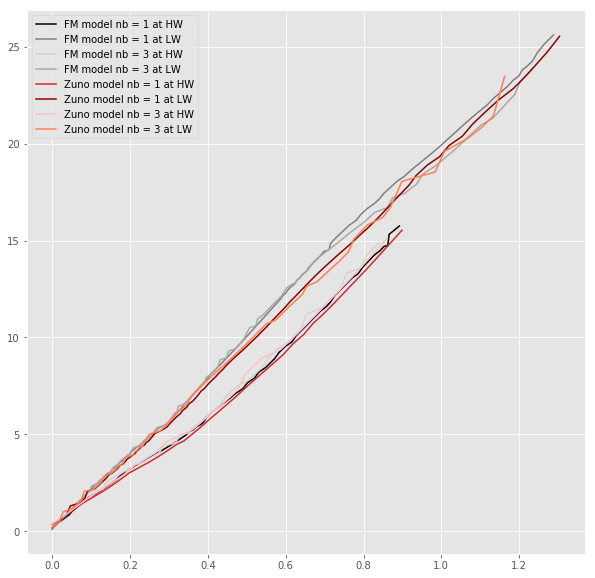

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(8):
    plt.plot(
        (time_paths[i][:-1] - time_paths[i][0]) / 3600,
        distances[i]/1000, 
        label = labels[i],
        color = colors[i]
            )

plt.legend()